# Supervised Object Classification
*Zhiang Chen, March 2017*
- Xazier initialization
- Dropout
- Rectified linear units
- Leaky ReLU
- Batch normalization

### 1. Import necessary packages

In [1]:
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
import random
import operator
import time
import os
import math

### 2. Import data

In [2]:
os.chdir('..')
file_name = 'depth_data'
with open(file_name, 'rb') as f:
    save = pickle.load(f)
    train_objects = save['train_objects']
    train_orientations = save['train_orientations']
    train_values = save['train_values']
    valid_objects = save['valid_objects']
    valid_orientations = save['valid_orientations']
    valid_values = save['valid_values']
    test_objects = save['test_objects']
    test_orientations = save['test_orientations']
    test_values = save['test_values']
    value2object = save['value2object']
    object2value = save['object2value']
    del save
    
print('training dataset', train_objects.shape, train_orientations.shape, train_values.shape)
print('validation dataset', valid_objects.shape, valid_orientations.shape, valid_values.shape)
print('testing dataset', test_objects.shape, test_orientations.shape, test_values.shape)

('training dataset', (47520, 11), (47520, 10), (47520, 50, 50, 1))
('validation dataset', (7920, 11), (7920, 10), (7920, 50, 50, 1))
('testing dataset', (7920, 11), (7920, 10), (7920, 50, 50, 1))


### 3. Shuffle data

In [3]:
def randomize(dataset, classes, angles):
    permutation = np.random.permutation(classes.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_classes = classes[permutation]
    shuffled_angles = angles[permutation]
    return shuffled_dataset, shuffled_classes, shuffled_angles

train_dataset, train_classes, train_angles = randomize(train_values, train_objects, train_orientations)
valid_dataset, valid_classes, valid_angles = randomize(valid_values, valid_objects, valid_orientations)
test_dataset, test_classes, test_angles = randomize(test_values, test_objects, test_orientations)

### 4. Verify data

class: nerf
orientation: 108


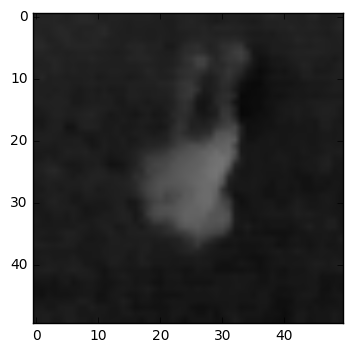

class: pball
orientation: 0


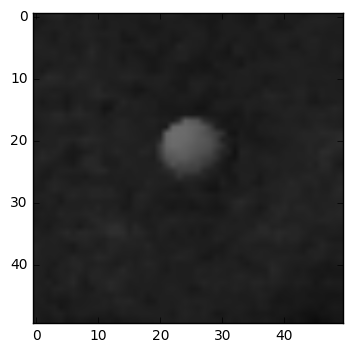

class: cup
orientation: 0


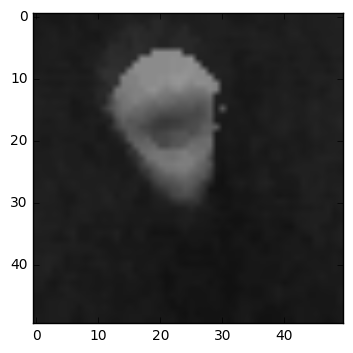

In [4]:
image_size = 50

def visualize(dataset, classes, angles, index):
    image = dataset[index,:,:].reshape(image_size, image_size).astype(np.float32)
    clas = classes[index,:]
    angle = angles[index,:]
    print('class: %s' % value2object[np.argmax(clas)])
    print('orientation: %d' % (np.argmax(angle)*18))
    plt.imshow(image,cmap='Greys_r',vmin=-0.6,vmax=0.4)
    plt.show()
    
visualize(train_dataset, train_classes, train_angles, random.randint(0,train_dataset.shape[0]))
visualize(valid_dataset, valid_classes, valid_angles, random.randint(0,valid_dataset.shape[0]))
visualize(test_dataset, test_classes, test_angles, random.randint(0,test_dataset.shape[0]))

### 5. Define some functions

In [5]:
def leaky_relu(x, leak=0.1):
    return tf.maximum(x, x * leak)

### 5. Build network
- Xavier initialization
- Batch normalization
- Leaky ReLU
- Replace all pooling layers
- Dropout

`
image: (50x50x1)
k1: (6x6,s=1)
map1: (45x45x16)
k2: (3x3,s=2)
map2: (22x22x16)
k3: (6x6,s=1)
map3: (17x17x32)
k4: (3x3,s=2)
map4: (8x8x32)
k5: (3x3,s=1)
map5: (6x6x64)
k6: (2x2,s=2)
map6: (3x3x64)
`

In [6]:
image_size = 50

k1_size = 6
k1_stride = 1
k1_depth = 1
k1_nm = 16
n1 = image_size*image_size*1

k2_size = 3
k2_stride = 2
k2_depth = 16
k2_nm = 16
m1_size = image_size-k1_size+k1_stride
n2 = m1_size*m1_size*k1_nm

k3_size = 6
k3_stride = 1
k3_depth = 16
k3_nm = 32
m2_size = (m1_size-k2_size)/k2_stride+1
n3 = m2_size*m2_size*k2_nm

k4_size = 3
k4_stride = 2
k4_depth = 32
k4_nm = 32
m3_size = (m2_size-k3_size)/k3_stride+1
n4 = m3_size*m3_size*k3_nm

k5_size = 3
k5_stride = 1
k5_depth = 32
k5_nm = 64
m4_size = (m3_size-k4_size)/k4_stride+1
n5 = m4_size*m4_size*k4_nm

k6_size = 2
k6_stride = 2
k6_depth = 64
k6_nm = 64
m5_size = (m4_size-k5_size)/k5_stride+1
n6 = m5_size*m5_size*k5_nm

f7_size = 120
m6_size = (m5_size-k6_size)/k6_stride+1
n7 = m6_size*m6_size*k6_nm

f8_size = 60
n8 = f7_size

classes_size = 11
n9 = f8_size

keep_prob1 = 0.8
keep_prob2 = 0.5

batch_size = 33

graph = tf.Graph()

with graph.as_default():
    '''Input data'''
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, k1_depth))
    # k1_depth = input_channels
    # convolution's input is a tensor of shape [batch,in_height,in_width,in_channels]
    tf_train_classes = tf.placeholder(tf.float32, shape=(batch_size, 11))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    '''Xavier initialization'''
    k1_stddev = math.sqrt(1.0/n1)
    k1_weights = tf.Variable(tf.truncated_normal([k1_size, k1_size, k1_depth, k1_nm], stddev = k1_stddev))
    k1_biases = tf.Variable(tf.zeros([k1_nm]))
    
    k2_stddev = math.sqrt(2.0/n2)
    k2_weights = tf.Variable(tf.truncated_normal([k2_size, k2_size, k2_depth, k2_nm], stddev = k2_stddev))
    k2_biases = tf.Variable(tf.zeros([k2_nm]))
    
    k3_stddev = math.sqrt(2.0/n3)
    k3_weights = tf.Variable(tf.truncated_normal([k3_size, k3_size, k3_depth, k3_nm], stddev = k3_stddev))
    k3_biases = tf.Variable(tf.zeros([k3_nm]))
    
    k4_stddev = math.sqrt(2.0/n4)
    k4_weights = tf.Variable(tf.truncated_normal([k4_size, k4_size, k4_depth, k4_nm], stddev = k4_stddev))
    k4_biases = tf.Variable(tf.zeros([k4_nm]))
    
    k5_stddev = math.sqrt(2.0/n5)
    k5_weights = tf.Variable(tf.truncated_normal([k5_size, k5_size, k5_depth, k5_nm], stddev = k5_stddev))
    k5_biases = tf.Variable(tf.zeros([k5_nm]))
    
    k6_stddev = math.sqrt(2.0/n6)
    k6_weights = tf.Variable(tf.truncated_normal([k6_size, k6_size, k6_depth, k6_nm], stddev = k6_stddev))
    k6_biases = tf.Variable(tf.zeros([k6_nm]))
    
    f7_stddev = math.sqrt(2.0/n7)
    f7_classes_weights = tf.Variable(tf.truncated_normal([n7, f7_size], stddev = f7_stddev))
    f7_classes_biases = tf.Variable(tf.zeros([f7_size]))
    
    f8_stddev = math.sqrt(2.0/n8)
    f8_classes_weights = tf.Variable(tf.truncated_normal([n8, f8_size], stddev = f8_stddev))
    f8_classes_biases = tf.Variable(tf.zeros([f8_size]))
    
    f9_stddev = math.sqrt(2.0/n9)
    f9_classes_weights = tf.Variable(tf.truncated_normal([n9, classes_size], stddev = f9_stddev))
    f9_classes_biases = tf.Variable(tf.zeros([classes_size]))
    
    #print n1,n2,n3,n4,n5,n6,n7,n8,n9
    #print k1_stddev,k2_stddev,k3_stddev,k4_stddev,k5_stddev,k6_stddev,f7_stddev,f8_stddev,f9_stddev
    
    '''Batch normalization initialization'''
    beta1 = tf.Variable(tf.zeros([k1_nm]))
    gamma1 = tf.Variable(tf.ones([k1_nm]))
    
    beta2 = tf.Variable(tf.zeros([k2_nm]))
    gamma2 = tf.Variable(tf.ones([k2_nm]))
    
    beta3 = tf.Variable(tf.zeros([k3_nm]))
    gamma3 = tf.Variable(tf.ones([k3_nm]))
    
    beta4 = tf.Variable(tf.zeros([k4_nm]))
    gamma4 = tf.Variable(tf.ones([k4_nm]))

    beta5 = tf.Variable(tf.zeros([k5_nm]))
    gamma5 = tf.Variable(tf.ones([k5_nm]))
    
    beta6 = tf.Variable(tf.zeros([k6_nm]))
    gamma6 = tf.Variable(tf.ones([k6_nm]))
    
    '''Models'''
    def train_model(data):
        conv = tf.nn.conv2d(data, k1_weights, [1, 1, 1, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta1,gamma1,1e-5)
        hidden = leaky_relu(y)
        
        conv = tf.nn.conv2d(hidden, k2_weights, [1, 2, 2, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta2,gamma2,1e-5)
        hidden = leaky_relu(y)
     
        conv = tf.nn.conv2d(hidden, k3_weights, [1, 1, 1, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta3,gamma3,1e-5)
        hidden = leaky_relu(y)
         
        conv = tf.nn.conv2d(hidden, k4_weights, [1, 2, 2, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta4,gamma4,1e-5)
        hidden = leaky_relu(y)
        
        conv = tf.nn.conv2d(hidden, k5_weights, [1, 1, 1, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta5,gamma5,1e-5)
        hidden = leaky_relu(y)
      
        conv = tf.nn.conv2d(hidden, k6_weights, [1, 2, 2, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta6,gamma6,1e-5)
        hidden = leaky_relu(y)
  
        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        hidden_input = tf.nn.dropout(reshape,keep_prob1) # dropout on the input layer
        
        hidden_classes = leaky_relu(tf.matmul(hidden_input, f7_classes_weights) + f7_classes_biases)
        
        hidden_classes = tf.nn.dropout(hidden_classes, keep_prob2) # dropout on the first FC layer
        
        fc_classes = tf.matmul(hidden_classes,f8_classes_weights)
        hidden_classes = leaky_relu(fc_classes + f8_classes_biases)
        
        fc_classes = tf.matmul(hidden_classes,f9_classes_weights)
        output_classes = fc_classes + f9_classes_biases
    
        return output_classes
    
    def test_model(data):
        conv = tf.nn.conv2d(data, k1_weights, [1, 1, 1, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta1,gamma1,1e-5)
        hidden = leaky_relu(y)
        
        conv = tf.nn.conv2d(hidden, k2_weights, [1, 2, 2, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta2,gamma2,1e-5)
        hidden = leaky_relu(y)
     
        conv = tf.nn.conv2d(hidden, k3_weights, [1, 1, 1, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta3,gamma3,1e-5)
        hidden = leaky_relu(y)
         
        conv = tf.nn.conv2d(hidden, k4_weights, [1, 2, 2, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta4,gamma4,1e-5)
        hidden = leaky_relu(y)
        
        conv = tf.nn.conv2d(hidden, k5_weights, [1, 1, 1, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta5,gamma5,1e-5)
        hidden = leaky_relu(y)
      
        conv = tf.nn.conv2d(hidden, k6_weights, [1, 2, 2, 1], padding='VALID')
        mean, variance = tf.nn.moments(conv, [0, 1, 2])
        y = tf.nn.batch_normalization(conv,mean,variance,beta6,gamma6,1e-5)
        hidden = leaky_relu(y)
  
        shape = hidden.get_shape().as_list()
        hidden_input = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        
        hidden_classes = leaky_relu(tf.matmul(hidden_input, f7_classes_weights) + f7_classes_biases)
        
        fc_classes = tf.matmul(hidden_classes,f8_classes_weights)
        hidden_classes = leaky_relu(fc_classes + f8_classes_biases)
        
        fc_classes = tf.matmul(hidden_classes,f9_classes_weights)
        output_classes = fc_classes + f9_classes_biases
    
        return output_classes
    
    '''Optimizer'''
    logits_classes = train_model(tf_train_dataset)
    loss_classes = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits_classes, labels = tf_train_classes))
    optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss_classes)
    # maybe better opt
    
    '''Predictions'''
    train_classes_logits = test_model(tf_train_dataset)
    train_classes_prediction = tf.nn.softmax(train_classes_logits)
    
    valid_classes_logits = test_model(tf_valid_dataset)
    valid_classes_prediction = tf.nn.softmax(valid_classes_logits)
    
    test_classes_logits = test_model(tf_test_dataset)
    test_classes_prediction = tf.nn.softmax(test_classes_logits)

### 7. Train network

In [7]:
def accuracy_classes(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Initialized
Minibatch loss at step 0: 2.899104
Minibatch classes accuracy: 3.0%
Validation classes accuracy: 11.1%
--------------------------------------
Minibatch loss at step 100: 1.412984
Minibatch classes accuracy: 60.6%
Validation classes accuracy: 77.4%
--------------------------------------
Minibatch loss at step 200: 0.934302
Minibatch classes accuracy: 75.8%
Validation classes accuracy: 83.5%
--------------------------------------
Minibatch loss at step 300: 0.789781
Minibatch classes accuracy: 84.8%
Validation classes accuracy: 92.3%
--------------------------------------
Minibatch loss at step 400: 0.580708
Minibatch classes accuracy: 93.9%
Validation classes accuracy: 92.6%
--------------------------------------
Minibatch loss at step 500: 0.454689
Minibatch classes accuracy: 90.9%
Validation classes accuracy: 92.5%
--------------------------------------
Minibatch loss at step 600: 0.183890
Minibatch classes accuracy: 100.0%
Validation classes accuracy: 94.3%
--------------

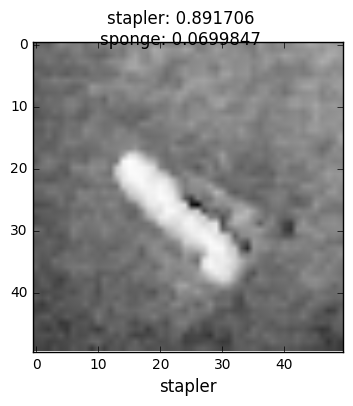

Input an index of test image (or Enter to quit): 1


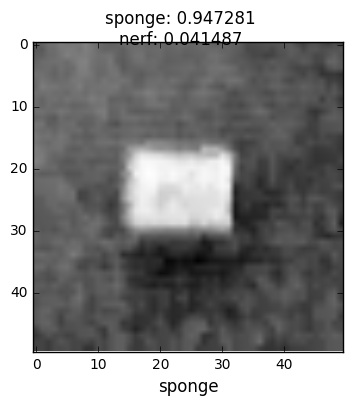

Input an index of test image (or Enter to quit): 3


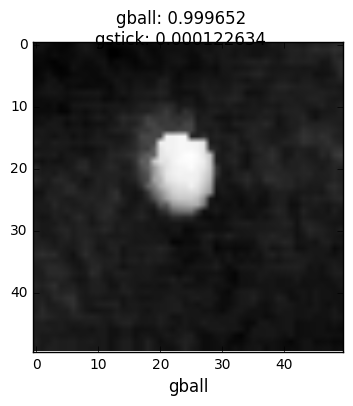

Input an index of test image (or Enter to quit): 4


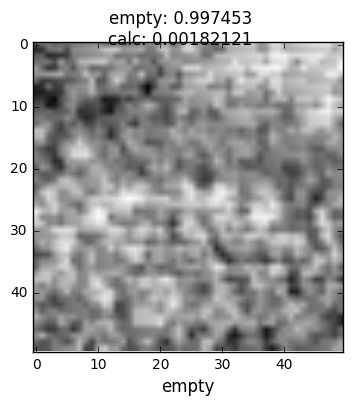

Input an index of test image (or Enter to quit): 5


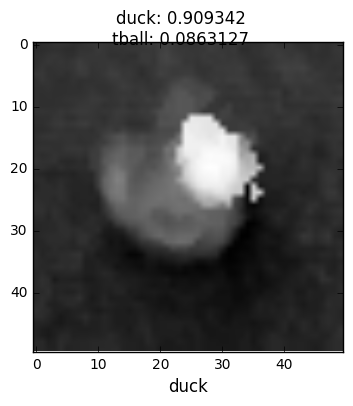

Input an index of test image (or Enter to quit): 6


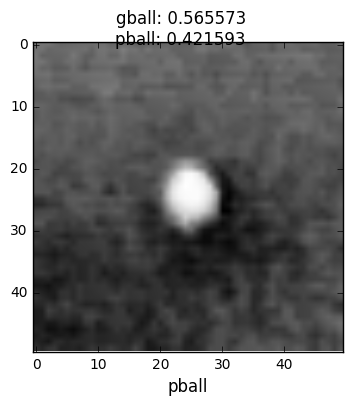

Input an index of test image (or Enter to quit): 7


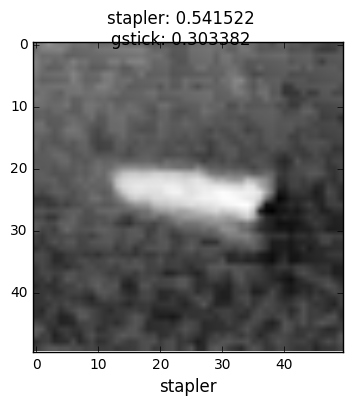

Input an index of test image (or Enter to quit): 8


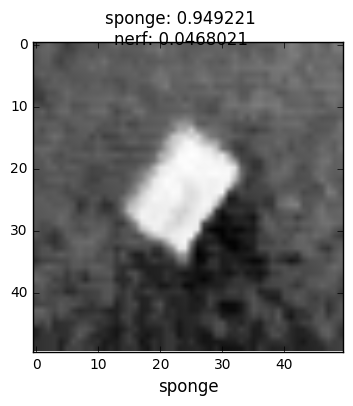

Input an index of test image (or Enter to quit): 9


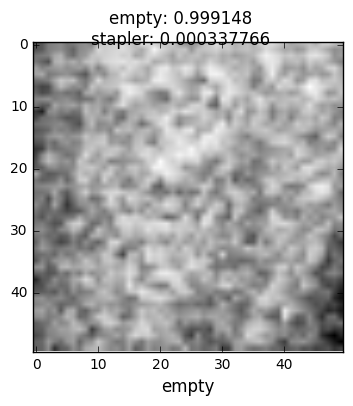

Input an index of test image (or Enter to quit): 
Exit


In [14]:
start_time = time.time()

num_steps = 1000
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
config.log_device_placement = True
with tf.Session(graph=graph, config = config) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_classes.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_classes = train_classes[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_classes : batch_classes}
    _, l, classes_predictions = session.run(
      [optimizer, loss_classes, train_classes_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch classes accuracy: %.1f%%' % accuracy_classes(classes_predictions, batch_classes))
      print('Validation classes accuracy: %.1f%%' % accuracy_classes(valid_classes_prediction.eval(), valid_classes))
      print('--------------------------------------')
  print('Test classes accuracy: %.1f%%' % accuracy_classes(test_classes_prediction.eval(), test_classes))
  end_time = time.time()
  duration = (end_time - start_time)/60
  print("Excution time: %0.2fmin" % duration)
  i_test = 0
  try:
    while(i_test!=''):
      i_test = input("Input an index of test image (or Enter to quit): ")
      label = test_classes[int(i_test),:].tolist()
      #print("Correct label: "+value2name[label.index(1)])
      image = test_dataset[int(i_test):int(i_test)+5,:,:,:].reshape((-1,image_size,image_size,1)).astype(np.float32)
      prediction = tf.nn.softmax(test_model(image))
      pre_dict = dict(zip(list(range(11)),prediction.eval()[0]))
      sorted_pre_dict = sorted(pre_dict.items(), key=operator.itemgetter(1))
      name1 = value2object[sorted_pre_dict[-1][0]]
      value1 = str(sorted_pre_dict[-1][1])
      name2 = value2object[sorted_pre_dict[-2][0]]
      value2 = str(sorted_pre_dict[-2][1])
      tile = name1+': '+value1+'\n'+name2+': '+value2
      image = image[0,:,:,:]
      image = image.reshape((image_size,image_size)).astype(np.float32)
      plt.imshow(image,cmap='Greys_r')
      plt.suptitle(tile, fontsize=12)
      plt.xlabel(value2object[label.index(1)], fontsize=12)
      plt.show()
  except:
    print('Exit')